# Week 9
# Make Predictions on NYC Taxi Data

In Week 8 notebook, we have explored the content of [NYC Taxi Data](https://www.kaggle.com/c/nyc-taxi-trip-duration/data). This week, we will use numerical and graphical tools to discover the relationship between taxi trip duration and other relavent variables, so that we can make predictions on the test data set.

## Create functions to streamline data pre-processing
- Download and unzip the data file from Kaggle.
- Load the dataset and remove dubious records.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import folium
%matplotlib inline 

In [3]:
def unzip_training_data(download_path, unzip_path):
    
    if os.path.exists(unzip_path + "train.csv"):
        print("File train.csv already exists.")
        return
    
    file_name = download_path + "nyc-taxi-trip-duration.zip"
    with zipfile.ZipFile(file_name, "r") as f:
        f.extractall(unzip_path)
        
    file_name = unzip_path + "train.zip"
    with zipfile.ZipFile(file_name, "r") as f:
        f.extractall(unzip_path)
        print("File train.csv has been created.")

In [5]:
# Unzip the training data
unzip_training_data("C:/Users/lzhao/Downloads/", "Data/nyctaxi/")

File train.csv already exists.


In [6]:
def load_training_data(data_path):
    
    # Check if train.csv exists.
    assert os.path.exists(data_path + "train.csv"), "File train.csv does not exist."
    
    # Load train.csv as a data frame
    raw_data = pd.read_csv(data_path + "train.csv", sep=',')
    
    # Adjust data types
    raw_data['pickup_datetime'] = raw_data['pickup_datetime'].astype(np.datetime64)
    raw_data['dropoff_datetime'] = raw_data['dropoff_datetime'].astype(np.datetime64)

    # Remove trips that are too long or too short
    upper_trip_limit = 7200
    lower_trip_limit = 60
    long_trips = raw_data[raw_data['trip_duration'] > upper_trip_limit]
    data = raw_data.drop(long_trips.index)
    short_trips = data[data['trip_duration'] < lower_trip_limit]
    data = data.drop(short_trips.index)
    
    # Remove locations that are not in NYC.
    data_not_nyc = data[(data['pickup_longitude'] < -74.1) | (data['pickup_longitude'] > -73.7) |
                        (data['pickup_latitude'] < 40.5) | (data['pickup_latitude'] > 40.9) |
                        (data['dropoff_longitude'] < -74.1) | (data['dropoff_longitude'] > -73.7) |
                        (data['dropoff_latitude'] < 40.5) | (data['dropoff_latitude'] > 40.9)]
    data = data.drop(data_not_nyc.index)
    
    # Remove irrelavent columns
    data = data.drop(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'dropoff_datetime'], axis=1)
    
    print("Shape:", data.shape)
    
    return data

In [7]:
# Load the training data
data = load_training_data("Data/nyctaxi/")

Shape: (1443264, 6)


In [8]:
data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435


# Examine the bivariate relationships
Examine the relationship of a single feature and the trip duration


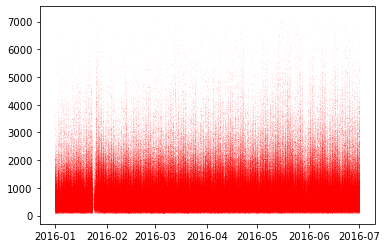

In [9]:
# How is pick-up date time related to trip duration?
plt.plot(data['pickup_datetime'], data['trip_duration'], 'r,', alpha=0.05)

Text(0, 0.5, 'Trip Duration (sec)')

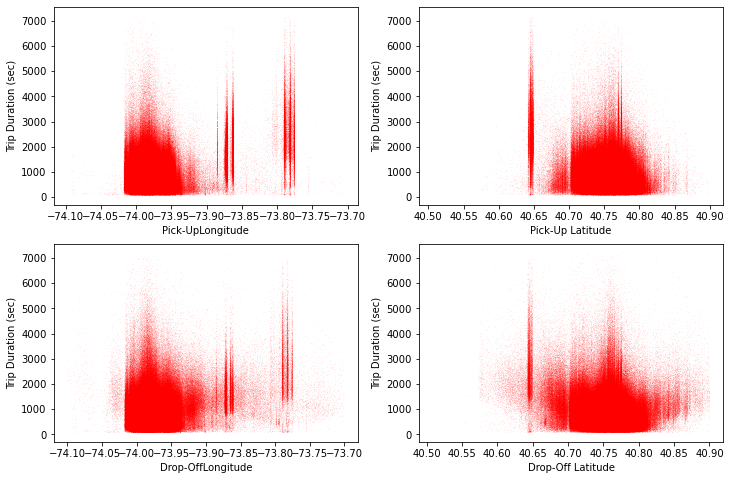

In [10]:
# How is pick-up and drop-off location related to trip duration?
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(data['pickup_longitude'], data['trip_duration'], 'r,', alpha=0.05)
ax1.set_xlabel("Pick-UpLongitude")
ax1.set_ylabel("Trip Duration (sec)")

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(data['pickup_latitude'], data['trip_duration'], 'r,', alpha=0.05)
ax2.set_xlabel("Pick-Up Latitude")
ax2.set_ylabel("Trip Duration (sec)")

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(data['dropoff_longitude'], data['trip_duration'], 'r,', alpha=0.05)
ax3.set_xlabel("Drop-OffLongitude")
ax3.set_ylabel("Trip Duration (sec)")

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(data['dropoff_latitude'], data['trip_duration'], 'r,', alpha=0.05)
ax4.set_xlabel("Drop-Off Latitude")
ax4.set_ylabel("Trip Duration (sec)")


In [11]:
# Calculate a numerical statistic called "correlation coefficient"
data.corr()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
pickup_longitude,1.000000,-0.139483,0.254035,0.045584,0.370884
pickup_latitude,-0.139483,1.000000,0.067225,0.427869,-0.240371
dropoff_longitude,0.254035,0.067225,1.000000,0.109328,0.267413
dropoff_latitude,0.045584,0.427869,0.109328,1.000000,-0.188722
trip_duration,0.370884,-0.240371,0.267413,-0.188722,1.000000


### Correlation Coefficient
The **correlation coefficient** is a numerical measurement of *linear* correlation between two variables.
- The value of correlation coefficient always lies in [-1, 1].
- If there is a strong positive correlation, then the coefficient is close to 1.
- If there is a strong negative correlation, then the coefficient is close to -1.
- If there is a very weak correlation, then the coefficient is close to 0.
- However, a near-zero coeffient may be caused by non-linear correlations.
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

**It looks like the relationship between trip durations and other features cannot be seen directly.**

## Feature Engineering
- Create additional useful features
    - Distance between pick-up and drop-off
    - Hour of the day
    - Day of the week
    - Holidays?
    - Weather?

In [12]:
# Create a column representing the aerial distance between pickup and dropoff
# Aerial distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def aerial_distance(record):
    
    return np.sqrt((record['pickup_longitude'] - record['dropoff_longitude']) ** 2 + \
                   (record['pickup_latitude'] - record['dropoff_latitude']) ** 2)

In [16]:
aerial_distance(data.loc[0, :])

0.017679539499584833

In [17]:
data['aerial_distance'] = data.apply(aerial_distance, axis=1) # add axis=1 to make sure it is applied along the vertical axis

In [20]:
# This statement caculates the aerial distances faster, but it is less readable.
data['aerial_distance'] = np.sqrt((data['pickup_longitude'] - data['dropoff_longitude']) ** 2 + \
                        (data['pickup_latitude'] - data['dropoff_latitude']) ** 2)

In [21]:
data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455,0.017680
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663,0.020456
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124,0.059934
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429,0.013438
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435,0.010690


In [22]:
# Add hours of the day
data['hour'] = data['pickup_datetime'].dt.hour

data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455,0.017680,17
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663,0.020456,0
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124,0.059934,11
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429,0.013438,19
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435,0.010690,13


In [23]:
# Add day of the week
data['day'] = data['pickup_datetime'].dt.dayofweek

data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455,0.017680,17,0
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663,0.020456,0,6
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124,0.059934,11,1
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429,0.013438,19,2
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435,0.010690,13,5


In [24]:
data.corr()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day
pickup_longitude,1.000000,-0.139483,0.254035,0.045584,0.370884,0.555045,0.019211,-0.030674
pickup_latitude,-0.139483,1.000000,0.067225,0.427869,-0.240371,-0.327076,0.013355,-0.034880
dropoff_longitude,0.254035,0.067225,1.000000,0.109328,0.267413,0.445814,-0.050962,-0.000992
dropoff_latitude,0.045584,0.427869,0.109328,1.000000,-0.188722,-0.175407,0.014891,-0.024624
trip_duration,0.370884,-0.240371,0.267413,-0.188722,1.000000,0.767537,0.029760,-0.034554
aerial_distance,0.555045,-0.327076,0.445814,-0.175407,0.767537,1.000000,-0.017953,0.005990
hour,0.019211,0.013355,-0.050962,0.014891,0.029760,-0.017953,1.000000,-0.084112
day,-0.030674,-0.034880,-0.000992,-0.024624,-0.034554,0.005990,-0.084112,1.000000


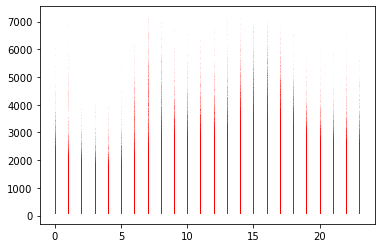

In [25]:
plt.plot(data['hour'], data['trip_duration'], 'r,', alpha=0.05)

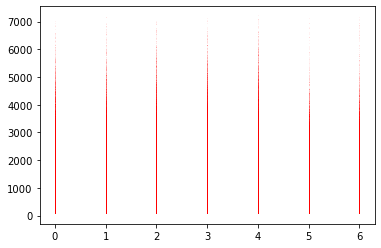

In [26]:
plt.plot(data['day'], data['trip_duration'], 'r,', alpha=0.05)

# Make Predictions

To make predictions, data scientists need to create a **mathematical model** that explictly describe how the prediction can be computed from the data. Often times the model comes with a set of tunable parameters whose values are determined by a **training algorithm**. The field of designing models and algorithms for computers to explore relationships in a data set is called **machine learning**. It is one of the most successful approach towards building **artificial intelligence**.

Today, we will employ a straight-forward strategy called **k-nearest-neighbors** to prediction trip durations for records in the test set.

- For each record that requires prediction, find **k** similar records from the training set with known trip durations.
- Since these records share similar attributes, their trips durations should be similar too.
- Use average trip duration of the k records as the prediction for the new record.

<img src="https://www.researchgate.net/profile/Debo_Cheng/publication/293487460/figure/fig1/AS:651874571149316@1532430417078/An-example-of-kNN-classification-task-with-k-5.png" width="600">

In [27]:
# Load test.csv
data_path = "Data/nyctaxi/"
with zipfile.ZipFile(data_path + "test.zip", "r") as f:
    f.extractall(data_path)
    
test_data = pd.read_csv(data_path + "test.csv", sep=",")

test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [28]:
# Change the data type of pick-up datetime
test_data['pickup_datetime'] = test_data['pickup_datetime'].astype(np.datetime64)

# Add hour of the day and day of the week
test_data['day'] = test_data['pickup_datetime'].dt.dayofweek

test_data['hour'] = test_data['pickup_datetime'].dt.hour

# drop irrelavant features
remove_cols = ['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']
test_data = test_data.drop(remove_cols, axis=1)

test_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day,hour
0,2016-06-30 23:59:58,-73.988129,40.732029,-73.990173,40.756680,3,23
1,2016-06-30 23:59:53,-73.964203,40.679993,-73.959808,40.655403,3,23
2,2016-06-30 23:59:47,-73.997437,40.737583,-73.986160,40.729523,3,23
3,2016-06-30 23:59:41,-73.956070,40.771900,-73.986427,40.730469,3,23
4,2016-06-30 23:59:33,-73.970215,40.761475,-73.961510,40.755890,3,23


In [51]:
# Extract the first record
test_1 = test_data.loc[0, :]
test_1

pickup_datetime      2016-06-30 23:59:58
pickup_longitude                -73.9881
pickup_latitude                   40.732
dropoff_longitude               -73.9902
dropoff_latitude                 40.7567
day                                    3
hour                                  23
Name: 0, dtype: object

In [52]:
# Let's visualize this new record
nyc = folium.Map(location=[40.7128, -74.0060],
                 zoom_start=12)
folium.Marker(location=[40.732, -73.988], popup="Pick Up", icon=folium.Icon(color='blue')).add_to(nyc)
folium.Marker(location=[40.7567, -73.99], popup="Drop Off", icon=folium.Icon(color='red')).add_to(nyc)
nyc

In [53]:
# Let's compare test_1 to the first 5 records in the training set
data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day,similarity_test_1,diff_coordinates,diff_day,diff_hour
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455,0.017680,17,0,47.173676,0.076347,3.0,6.0
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663,0.020456,0,6,NaN,NaN,NaN,NaN
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124,0.059934,11,1,NaN,NaN,NaN,NaN
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429,0.013438,19,2,NaN,NaN,NaN,NaN
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435,0.010690,13,5,NaN,NaN,NaN,NaN


In [54]:
nyc = folium.Map(location=[40.7128, -74.0060],
                 zoom_start=12)
folium.Marker(location=[40.7679, -73.9821], popup="Pick Up", icon=folium.Icon(color='blue')).add_to(nyc)
folium.Marker(location=[40.7656, -73.9646], popup="Drop Off", icon=folium.Icon(color='red')).add_to(nyc)
nyc

In [55]:
# Try to find similar records to test_1
# test_1 occurs at 11PM on Wednesday
data_similar = data[(data['hour'] == 23) & (data['day'] == 3)]
data_similar

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day,similarity_test_1,diff_coordinates,diff_day,diff_hour
37,2016-06-23 23:00:09,-73.988068,40.728081,-73.980751,40.721470,277,0.009861,23,3,NaN,NaN,NaN,NaN
96,2016-06-02 23:34:00,-73.973465,40.755230,-73.977364,40.742821,435,0.013007,23,3,NaN,NaN,NaN,NaN
122,2016-01-07 23:24:44,-73.999298,40.749535,-74.005363,40.743519,101,0.008543,23,3,NaN,NaN,NaN,NaN
685,2016-06-16 23:42:22,-73.985199,40.747780,-73.979050,40.741264,312,0.008959,23,3,NaN,NaN,NaN,NaN
1010,2016-04-14 23:10:38,-73.875610,40.771442,-73.911514,40.769379,855,0.035963,23,3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457501,2016-01-07 23:48:15,-73.965767,40.760315,-73.933945,40.770172,710,0.033314,23,3,NaN,NaN,NaN,NaN
1457689,2016-03-24 23:25:06,-73.975426,40.763199,-73.831932,40.854588,1868,0.170124,23,3,NaN,NaN,NaN,NaN
1458217,2016-02-18 23:44:06,-73.939926,40.678123,-73.932762,40.686733,302,0.011200,23,3,NaN,NaN,NaN,NaN
1458515,2016-01-21 23:46:30,-73.927818,40.744411,-73.926216,40.762413,485,0.018073,23,3,NaN,NaN,NaN,NaN


In [56]:
nyc = folium.Map(location=[40.7128, -74.0060],
                 zoom_start=12)
folium.Marker(location=[40.7280, -73.9880], popup="Pick Up", icon=folium.Icon(color='blue')).add_to(nyc)
folium.Marker(location=[40.7214, -73.9807], popup="Drop Off", icon=folium.Icon(color='red')).add_to(nyc)
nyc

In [57]:
# Which record in the training data are similar to test_1?
# How to measure similarity?

# Let's use the following weighted sum of differences to measure similarity
# similarity = differences in coordinates * 500 + difference in days of the week + difference in hours

def similarity(training_record, test_record):
    
    diff_coordinates = np.abs(training_record['pickup_longitude'] - test_record['pickup_longitude']) + \
                        np.abs(training_record['pickup_latitude'] - test_record['pickup_latitude']) + \
                        np.abs(training_record['dropoff_longitude'] - test_record['dropoff_longitude']) + \
                        np.abs(training_record['dropoff_latitude'] - test_record['dropoff_latitude'])
    
    diff_day = np.abs(training_record['day'] - test_record['day'])
    
    diff_hour = np.abs(training_record['hour'] - test_record['hour'])
        
    return diff_coordinates * 500 + diff_day + diff_hour

In [58]:
similarity(data.loc[0, :], test_1)

47.17367553712003

In [59]:
# data['similarity_test_1'] = data.apply(similarity, args=(test_1,), axis=1)

# data.head()

In [61]:
# Applying similarity() tends to cost a long time. 
# We can do the calculation direction in the following way:

data['diff_coordinates'] = np.abs(data['pickup_longitude'] - test_1['pickup_longitude']) + \
                        np.abs(data['pickup_latitude'] - test_1['pickup_latitude']) + \
                        np.abs(data['dropoff_longitude'] - test_1['dropoff_longitude']) + \
                        np.abs(data['dropoff_latitude'] - test_1['dropoff_latitude'])

data['diff_day'] = np.abs(data['day'] - test_1['day'])

data['diff_hour'] = np.abs(data['hour'] - test_1['hour'])

data['similarity_test_1'] = data['diff_coordinates'] * 500 + data['diff_day'] + data['diff_hour']

data = data.drop(['diff_coordinates', 'diff_day', 'diff_hour'], axis=1)

data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day,similarity_test_1
0,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,455,0.017680,17,0,47.173676
1,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,663,0.020456,0,6,50.541855
2,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,2124,0.059934,11,1,65.382065
3,2016-04-06 19:32:31,-74.010040,40.719971,-74.012268,40.706718,429,0.013438,19,2,58.012848
4,2016-03-26 13:30:55,-73.973053,40.793209,-73.972923,40.782520,435,0.010690,13,5,71.673309


In [63]:
# Let's use k = 5
# Find the 5 closest records

data = data.sort_values(by=['similarity_test_1'])
data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,aerial_distance,hour,day,similarity_test_1
297728,2016-03-25 23:09:55,-73.988297,40.731476,-73.989517,40.756672,952,0.025226,23,4,1.692368
1398193,2016-04-20 23:52:44,-73.988487,40.731400,-73.989861,40.756882,796,0.025519,23,2,1.751495
856138,2016-06-16 23:26:13,-73.989189,40.730083,-73.989784,40.757233,822,0.027156,23,3,1.974106
809169,2016-03-10 22:54:37,-73.988708,40.731026,-73.989975,40.757084,662,0.026089,22,3,2.092911
899285,2016-03-16 23:38:38,-73.987595,40.733662,-73.990074,40.756565,520,0.023037,23,2,2.190186


In [64]:
# Where are the locations of these 5 records?
nyc = folium.Map(location=[40.7128, -74.0060],
                 zoom_start=12)

for ind in data.head().index:
    
    pickup_lat = data.loc[ind, 'pickup_latitude']
    pickup_long = data.loc[ind, 'pickup_longitude']
    dropoff_lat = data.loc[ind, 'dropoff_latitude']
    dropoff_long = data.loc[ind, 'dropoff_longitude']
    
    folium.Marker(location=[pickup_lat, pickup_long], popup="Pick Up", icon=folium.Icon(color='blue')).add_to(nyc)
    folium.Marker(location=[dropoff_lat, dropoff_long], popup="Drop Off", icon=folium.Icon(color='red')).add_to(nyc) 
    
nyc

In [65]:
# Let's use their average time as our prediction.
prediction_test_1 = data.head()['trip_duration'].mean()
print("Prediction:", prediction_test_1)

Prediction: 750.4
